In [1]:
#from speedml import Speedml
import csv
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from scipy import stats
import math
import seaborn as sns
from collections import OrderedDict
%matplotlib inline
import pg8000
import sys
import os
import pathlib2
import warnings
warnings.filterwarnings('ignore')
import mouse_primaryfamily_dict as mpfd
import data_modality_funcs as dmf

In [2]:
#Global variables
mouse_deadline = datetime.strptime('2018-09-30', "%Y-%m-%d")
human_deadline = datetime.strptime('2018-05-15', "%Y-%m-%d")
mouse_goal = 3500
human_goal = 400

In [3]:
def read_data(path):
    df = pd.read_csv(path)
    return df

In [4]:
def format_table(df):
    #convert dates to datetime object
    df['recording_date'] = pd.to_datetime(df['recording_date'], format='%Y-%m-%d')
    df['63x_call'].fillna("No look", inplace=True)
    #setting NaN res_index values to 1.1 for classification as pending_trans
    df['anno.res_index_label'].fillna(1.1, inplace=True)
    df = dmf.modality_reclass(df)
    return df

In [5]:
def pivot_table(df):
    df = df[['recording_date', 'modality class', 'cell_name']]
    df = df.groupby(['recording_date', 'modality class']).agg(['count'])
    df = df.reset_index()
    df = df.set_index(['recording_date', 'modality class']).unstack(level=-1).fillna(0).cumsum()
    return df

In [6]:
def list_dates(df):
    dates = sorted(tuple(df.index.unique()))
    return dates

In [7]:
def list_outcomes(df):
    triple_mod = tuple(df['cell_name', 'count', 'Triple Modality'])
    double_mod = tuple(df['cell_name', 'count', 'Double Modality'])
    ephys_only = tuple(df['cell_name', 'count', 'EPhys Only'])
    pending_morph = tuple(df['cell_name', 'count', 'Pending Morph'])
    pending_trans = tuple(df['cell_name', 'count', 'Pending Trans'])
    return triple_mod, double_mod, ephys_only, pending_trans, pending_morph

In [8]:
def get_current_date(df):
    current_date = pd.to_datetime(list_dates(df)[-1])
    return current_date

In [9]:
def get_current_total(df):
    total_trip, total_dub, total_ephys, total_morph_pend, total_trans_pend = list_outcomes(df)
    totals = total_trip[-1] + total_dub[-1] + total_ephys[-1] + total_morph_pend[-1] + total_trans_pend[-1]
    #total = triple_mod[-1] + double_mod[-1] + ephys_only[-1] + pending_morph[-1] + pending_trans[-1]
    return totals

In [10]:
def get_current_goal(df, species):
    d0 = pd.to_datetime(list_dates(df)[0])
    d1 = get_current_date(df)
    d2_mouse = mouse_deadline
    d2_human = human_deadline
    total_mouse_days = (d2_mouse - d0).days
    total_human_days = (d2_human - d0).days
    total2_today = (d1 - d0).days
    if species == 'mouse':
        current_goal = (mouse_goal/float(total_mouse_days))*total2_today
    else:
        if species == 'human':
            current_goal = (human_goal/float(total_human_days))*total2_today
    return current_goal

In [11]:
def get_goal_delta(df, species):
    if species == 'mouse':
        diff = get_current_total(df) - get_current_goal(df, 'mouse')
    else:
        if species == 'human':
            diff = get_current_total(df) - get_current_goal(df, 'human')
    return diff

In [12]:
def valid_input(prompt_text, invalid_response, valid_options=None):
    while True:
        result = raw_input(prompt_text)
        if (valid_options) and (result not in valid_options):
            print invalid_response
            continue
        else:
            break
    return result

In [13]:
#May need to either make a class to inherit from for plotting mouse and human or rename this "make_mouse_plot"
#and make another function called "make_human_plot".
def make_mouse_plot(df):

    x = list_dates(df) 
    y = list(list_outcomes(df))
    deadline = mouse_deadline
    
    colors = ["#08519c", "#3182bd", "#6baed6", "#969696", "#636363"]
    labels = ["Triple Modality", "Double Modality", "EPhys Only", "Pending Trans", "Pending Morph"]
    fig, ax = plt.subplots()
    plt.xticks(rotation=45, ha='right', size=7)
    plt.yticks(size=7)
    progress = ax.stackplot(x, y, labels = labels, colors=colors)
    goal_line = ax.plot([0,1], [0,1], color='g', transform=ax.transAxes)
    legend = ax.legend(loc=(0.05,0.9), prop = {'size':7}, frameon=False, labelspacing=-2.5)
    #plt.gcf().autofmt_xdate()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(['2018-01-02', '2018-09-30'])
    ax.set_ylim([0, 3500])
    ax.vlines(x='2018-09-30', ymin=0, ymax=mouse_goal, color='r')
    
    plt.title("2018 Mouse SMART Goal Progress", size=10)
    plt.ylabel('Patched Cells', size=10)
    plt.xlabel('Date', size=10)
    plt.text('2018-10-05', '3500', "{}".format("3500 cell goal"), size=7)
    plt.text(get_current_date(df), get_current_total(df), "{}".format(int(get_goal_delta(df, "mouse"))), size=7)
    
    if get_current_date(df) > deadline:
        plt.text(deadline, get_current_total(df), "{}".format(int(get_goal_delta(df, "mouse"))), size=7)
    else:
        if deadline > get_current_date(df):
            plt.text(get_current_date(df), get_current_total(df), "{}".format(int(get_goal_delta(df, "mouse"))), size=7)
    #plt.text('2018-10-05', '700', "{}".format("20% triple modality goal"))
    plt.text('2018-09-30', '-200', "{}".format("Deadline - 2018-09-30"), rotation=45, ha='right', size=7)
    fig.tight_layout()
    plt.savefig('../figures/Mouse_SMART_Goal_2018_Progress', dpi=300, bbox_inches="tight")

In [14]:
def mouse_pie_plot(df):
    df['family'] = df['drivers'].map(mpfd.make_dict())
    df = df[['drivers','family']]
    df = df.groupby(['family']).count().reset_index()
    
    slices = df['drivers']
    labels = df['family']

    slices = sorted(slices)

    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(111)

    #cmap = plt.cm.prism
    cmap = plt.cm.Blues
    colors = cmap(np.linspace(0., 1., len(slices)))

    ax.pie(slices, colors=colors, labels=labels, pctdistance=0.85, labeldistance=1.1, autopct='%1.1f%%')

    plt.title('Mouse Primary Families')
    #plt.tight_layout()
    plt.savefig('../figures/mouse_pie', dpi=300, bbox_inches="tight")

In [15]:
def make_human_plot(df):

    x = list_dates(df) 
    y = list(list_outcomes(df))
    deadline = human_deadline
    
    colors = ["#08519c", "#3182bd", "#6baed6", "#969696", "#636363"]
    labels = ["Triple Modality", "Double Modality", "EPhys Only", "Pending Trans", "Pending Morph"]
    fig, ax = plt.subplots()
    plt.xticks(rotation=45, ha='right', size=7)
    plt.yticks(size=7)
    progress = ax.stackplot(x, y, labels = labels, colors=colors)
    goal_line = ax.plot([0,1], [0,1], color='g', transform=ax.transAxes)
    legend = ax.legend(loc=(0.05,0.9), prop = {'size':7}, frameon=False, labelspacing=-2.5)
    #plt.gcf().autofmt_xdate()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(['2018-01-02', '2018-05-15'])
    ax.set_ylim([0, 400])
    ax.vlines(x='2018-05-15', ymin=0, ymax=human_goal, color='r')
    
    plt.title("2018 Human SMART Goal Progress", size=10)
    plt.ylabel('Patched Cells', size=10)
    plt.xlabel('Date', size=10)
    plt.text('2018-05-15', '400', "{}".format("400 cell goal"), size=7)
    
    if get_current_date(df) > deadline:
        plt.text(deadline, get_current_total(df), "{}".format(int(get_goal_delta(df, "human"))), size=7)
    else:
        if deadline > get_current_date(df):
            plt.text(get_current_date(df), get_current_total(df), "{}".format(int(get_goal_delta(df, "human"))), size=7)
    #plt.text('2018-10-05', '700', "{}".format("20% triple modality goal"))
    #plt.text('2018-05-15', '-30', "{}".format("Deadline - 2018-05-15"), rotation=45, ha='right', size=7)
    fig.tight_layout()
    plt.savefig('../figures/Human_SMART_Goal_2018_Progress', dpi=300, bbox_inches="tight")

In [16]:
def human_pie_plot(df):
    df['layer'].fillna(0, inplace=True)
    df['layer'] = df['layer'].astype(int)
    df = df.rename(columns = {'recording_date':'count'})
    df = df[['layer', 'count']]
    df = df.groupby(['layer']).count().reset_index()
    
    colors = ['#636363', '#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef']
    labels = ['N/A', '1', '2', '3', '4', '5', '6']

    ax1 = df.plot(kind = 'pie', y='count', labels=labels, autopct='%1.1f%%', pctdistance=0.85, labeldistance=1.1, legend=False,
                  title = 'Human Tissue Layer Patch', colors = colors, startangle = -60)
    plt.axes().set_ylabel('')

    ax1.axis('equal')
    plt.tight_layout()
    plt.savefig('../figures/Human_tissue_layer', dpi=300, bbox_inches="tight")

would you like to report on mouse (m) or human (h) smart goal data?:h


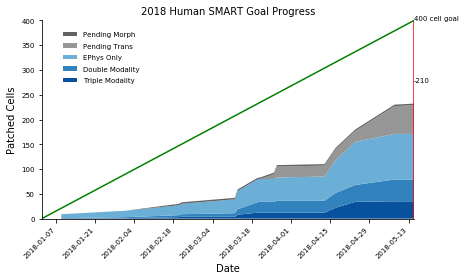

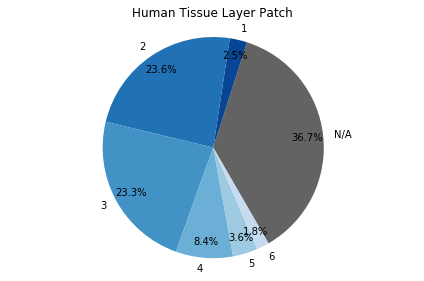

In [18]:
if __name__ == "__main__":
    
    str_prompt = "\nWould you like to report on mouse (m) or human (h) SMART goal data?: ".strip().lower()
    valid_vals = ['m', 'h']
    response = "\n{} is not a valid response, please enter either 'm' or 'h'".format(str_prompt)
    
    species = valid_input(str_prompt, response, valid_vals)
    
    if species == 'm':
        data = read_data("../data/mouse_smart_data.csv")
        formatted_data = format_table(data)
        pivoted_data = pivot_table(formatted_data)
        plot = make_mouse_plot(pivoted_data)
        pie_plot = mouse_pie_plot(formatted_data)
    else:
        if species == 'h':
            data = read_data("../data/human_smart_data.csv")
            formatted_data = format_table(data)
            pivoted_data = pivot_table(formatted_data)
            plot = make_human_plot(pivoted_data)
            pie_plot = human_pie_plot(formatted_data)